# Summary statistics

`ScmRun` objects have methods specific to calculating summary statistics. In this notebook we demonstrate them.

In [1]:
# NBVAL_IGNORE_OUTPUT
import traceback

import matplotlib.pyplot as plt
import numpy as np

from scmdata.run import ScmRun, run_append

In [2]:
plt.rcParams["figure.figsize"] = (12, 8)

## Helper bits and piecs

In [3]:
def new_timeseries(
    n=101,
    count=1,
    model="example",
    scenario="ssp119",
    variable="Surface Temperature",
    unit="K",
    region="World",
    cls=ScmRun,
    **kwargs,
):
    data = np.random.rand(n, count) * np.arange(n)[:, np.newaxis]
    index = 2000 + np.arange(n)
    return cls(
        data,
        columns={
            "model": model,
            "scenario": scenario,
            "variable": variable,
            "region": region,
            "unit": unit,
            **kwargs,
        },
        index=index,
    )

Let's create an `ScmRun` which contains a few variables and a number of runs. Such a dataframe would be used to store the results from an ensemble of simple climate model runs.

In [4]:
# NBVAL_IGNORE_OUTPUT
runs = run_append(
    [
        new_timeseries(
            count=3,
            variable=[
                "Surface Temperature",
                "Atmospheric Concentrations|CO2",
                "Radiative Forcing",
            ],
            unit=["K", "ppm", "W/m^2"],
            run_id=run_id,
        )
        for run_id in range(10)
    ]
)
runs.metadata["source"] = "fake data"
runs

<scmdata.ScmRun (timeseries: 30, timepoints: 101)>
Time:
	Start: 2000-01-01T00:00:00
	End: 2100-01-01T00:00:00
Meta:
	      model region  run_id scenario   unit                        variable
	0   example  World       0   ssp119      K             Surface Temperature
	1   example  World       0   ssp119    ppm  Atmospheric Concentrations|CO2
	2   example  World       0   ssp119  W/m^2               Radiative Forcing
	3   example  World       1   ssp119      K             Surface Temperature
	4   example  World       1   ssp119    ppm  Atmospheric Concentrations|CO2
	5   example  World       1   ssp119  W/m^2               Radiative Forcing
	6   example  World       2   ssp119      K             Surface Temperature
	7   example  World       2   ssp119    ppm  Atmospheric Concentrations|CO2
	8   example  World       2   ssp119  W/m^2               Radiative Forcing
	9   example  World       3   ssp119      K             Surface Temperature
	10  example  World       3   ssp119    ppm  At

## `process_over`

The `process_over` method allows us to calculate a specific set of statistics on groups of timeseries. A number of pandas functions can be called including "sum", "mean" and "describe".

In [5]:
print(runs.process_over.__doc__)


        Process the data over the input columns.

        Parameters
        ----------
        cols
            Columns to perform the operation on. The timeseries will be grouped by all
            other columns in :attr:`meta`.

        operation : str or func
            The operation to perform.

            If a string is provided the equivalent pandas
            function is used. Additional information about the arguments for the pandas
            groupby functions can be found at <https://pandas.pydata.org/pandas-docs/
            stable/reference/groupby.html>`_.

            If a function is provided, will be applied to each group. The function must
            take a dataframe as it's first argument and return a DataFrame, Series or scalar.

            Note that quantile means the value of the data at a given point in the cumulative
            distribution of values at each point in the timeseries, for each timeseries
            once the groupby is applied. As a result

### Mean

In [6]:
# NBVAL_IGNORE_OUTPUT
mean = runs.process_over(cols="run_id", operation="mean")
mean

time                                                          2000-01-01  2001-01-01  2002-01-01  2003-01-01  2004-01-01  2005-01-01  2006-01-01  ...  2094-01-01  2095-01-01  2096-01-01  2097-01-01  2098-01-01  2099-01-01  2100-01-01
model   region scenario unit  variable                                                                                                            ...                                                                                    
example World  ssp119   ppm   Atmospheric Concentrations|CO2         0.0    0.284974    0.812137    1.178220    2.157996    1.884415    3.488444  ...   36.844245   46.434265   51.715110   41.640504   36.968385   51.028876   42.405328
                        W/m^2 Radiative Forcing                      0.0    0.560291    0.984269    1.980072    2.141488    2.631997    2.604832  ...   54.425434   48.498988   51.738321   41.318396   45.699071   50.312449   46.107782
                        K     Surface Temperature                    0.0    0.495561    0.889523    1.535609    2.065011    2.113106    2.569650  ...   58.935812   56.851212   57.652793   53.086635   34.635853   28.780204   48.343132

[3 rows x 101 columns]

### Median

In [7]:
# NBVAL_IGNORE_OUTPUT
median = runs.process_over(cols="run_id", operation="median")
median

time                                                          2000-01-01  2001-01-01  2002-01-01  2003-01-01  2004-01-01  2005-01-01  2006-01-01  ...  2094-01-01  2095-01-01  2096-01-01  2097-01-01  2098-01-01  2099-01-01  2100-01-01
model   region scenario unit  variable                                                                                                            ...                                                                                    
example World  ssp119   ppm   Atmospheric Concentrations|CO2         0.0    0.265410    0.854882    0.860820    2.060200    1.070028    3.644174  ...   26.768065   40.881403   58.130479   44.478230   36.462175   62.394662   35.665582
                        W/m^2 Radiative Forcing                      0.0    0.606913    0.887070    2.154341    2.059845    2.693480    2.115705  ...   66.291939   44.513708   62.546776   31.616911   37.586904   53.625918   39.739471
                        K     Surface Temperature                    0.0    0.447325    0.712902    1.128667    2.430131    2.126400    2.456185  ...   71.713969   65.587076   52.943148   52.443165   17.981980   24.118553   43.267066

[3 rows x 101 columns]

### Arbitrary functions

You are also able to run arbitrary functions for each group

In [8]:
# NBVAL_IGNORE_OUTPUT
def mean_and_invert(df, axis=0):
    # Take a mean across the group and then invert the result
    return -df.mean(axis=axis)

runs.process_over("run_id", operation=mean_and_invert)

time                                                          2000-01-01  2001-01-01  2002-01-01  2003-01-01  2004-01-01  2005-01-01  2006-01-01  ...  2094-01-01  2095-01-01  2096-01-01  2097-01-01  2098-01-01  2099-01-01  2100-01-01
model   region scenario unit  variable                                                                                                            ...                                                                                    
example World  ssp119   ppm   Atmospheric Concentrations|CO2        -0.0   -0.284974   -0.812137   -1.178220   -2.157996   -1.884415   -3.488444  ...  -36.844245  -46.434265  -51.715110  -41.640504  -36.968385  -51.028876  -42.405328
                        W/m^2 Radiative Forcing                     -0.0   -0.560291   -0.984269   -1.980072   -2.141488   -2.631997   -2.604832  ...  -54.425434  -48.498988  -51.738321  -41.318396  -45.699071  -50.312449  -46.107782
                        K     Surface Temperature                   -0.0   -0.495561   -0.889523   -1.535609   -2.065011   -2.113106   -2.569650  ...  -58.935812  -56.851212  -57.652793  -53.086635  -34.635853  -28.780204  -48.343132

[3 rows x 101 columns]

In [9]:
# NBVAL_IGNORE_OUTPUT
runs.process_over("run_id", operation=mean_and_invert, axis=1)

model    region  run_id  scenario  unit   variable                      
example  World   0       ssp119    ppm    Atmospheric Concentrations|CO2   -25.030483
                 1       ssp119    ppm    Atmospheric Concentrations|CO2   -24.752223
                 2       ssp119    ppm    Atmospheric Concentrations|CO2   -25.174186
                 3       ssp119    ppm    Atmospheric Concentrations|CO2   -24.028201
                 4       ssp119    ppm    Atmospheric Concentrations|CO2   -24.233979
                 5       ssp119    ppm    Atmospheric Concentrations|CO2   -26.326721
                 6       ssp119    ppm    Atmospheric Concentrations|CO2   -21.185298
                 7       ssp119    ppm    Atmospheric Concentrations|CO2   -23.525704
                 8       ssp119    ppm    Atmospheric Concentrations|CO2   -23.073325
                 9       ssp119    ppm    Atmospheric Concentrations|CO2   -24.766342
                 0       ssp119    W/m^2  Radiative Forcing        

### Other quantiles

In [10]:
# NBVAL_IGNORE_OUTPUT
lower_likely_quantile = runs.process_over(
    cols="run_id", operation="quantile", q=0.17
)
lower_likely_quantile

time                                                          2000-01-01  2001-01-01  2002-01-01  2003-01-01  2004-01-01  2005-01-01  2006-01-01  ...  2094-01-01  2095-01-01  2096-01-01  2097-01-01  2098-01-01  2099-01-01  2100-01-01
model   region scenario unit  variable                                                                                                            ...                                                                                    
example World  ssp119   ppm   Atmospheric Concentrations|CO2         0.0    0.114464    0.142185    0.458533    1.403424    0.446332    1.860071  ...   10.092724   19.309552   22.150259   14.833751   12.657343   13.599492   10.956808
                        W/m^2 Radiative Forcing                      0.0    0.268680    0.199163    0.957845    0.610393    1.308334    0.935005  ...   26.813249   16.719730   27.664287    9.642687   22.273929   23.601475   20.789529
                        K     Surface Temperature                    0.0    0.205258    0.411664    0.774095    0.611518    1.489749    0.512609  ...   22.482359   24.909363   39.421663   25.040751   12.535632   17.350994   14.971051

[3 rows x 101 columns]

## `quantiles_over`

If you want to calculate more than one summary statistic, `quantiles_over` will calculate and label multiple summary statistics before returning them.

In [11]:
print(runs.quantiles_over.__doc__)


        Calculate quantiles of the data over the input columns.

        Parameters
        ----------
        cols
            Columns to perform the operation on. The timeseries will be grouped by all
            other columns in :attr:`meta`.

        quantiles
            The quantiles to calculate. This should be a list of quantiles to calculate
            (quantile values between 0 and 1). ``quantiles`` can also include the strings
            "median" or "mean" if these values are to be calculated.

        **kwargs
            Passed to :meth:`~ScmRun.process_over`.

        Returns
        -------
        :class:`pandas.DataFrame`
            The quantiles of the timeseries, grouped by all columns in :attr:`meta`
            other than :obj:`cols`. Each calculated quantile is given a label which is
            stored in the ``quantile`` column within the output index.

        Raises
        ------
        TypeError
            ``operation`` is included in ``kwargs``. The op

In [12]:
# NBVAL_IGNORE_OUTPUT
summary_stats = runs.quantiles_over(
    cols="run_id", quantiles=[0.05, 0.17, 0.5, 0.83, 0.95, "mean", "median"]
)
summary_stats

time                                                                   2000-01-01  2001-01-01  2002-01-01  2003-01-01  2004-01-01  2005-01-01  2006-01-01  ...  2094-01-01  2095-01-01  2096-01-01  2097-01-01  2098-01-01  2099-01-01  2100-01-01
model   region scenario unit  variable                       quantile                                                                                      ...                                                                                    
example World  ssp119   ppm   Atmospheric Concentrations|CO2 0.05             0.0    0.053357    0.024165    0.256830    0.613608    0.233549    1.302757  ...    6.062907    8.612691    9.662842   11.735235    4.210704    2.367877    5.592715
                        W/m^2 Radiative Forcing              0.05             0.0    0.142268    0.093940    0.421896    0.585657    0.727537    0.706385  ...   11.975430   15.176637    3.791854    5.250144   16.475851   11.416853    9.783106
                        K     Surface Temperature            0.05             0.0    0.070706    0.237747    0.395354    0.491465    0.731990    0.324952  ...    5.465390    4.978670   36.702388   13.291762    5.453391   13.287933    9.342035
                        ppm   Atmospheric Concentrations|CO2 0.17             0.0    0.114464    0.142185    0.458533    1.403424    0.446332    1.860071  ...   10.092724   19.309552   22.150259   14.833751   12.657343   13.599492   10.956808
                        W/m^2 Radiative Forcing              0.17             0.0    0.268680    0.199163    0.957845    0.610393    1.308334    0.935005  ...   26.813249   16.719730   27.664287    9.642687   22.273929   23.601475   20.789529
                        K     Surface Temperature            0.17             0.0    0.205258    0.411664    0.774095    0.611518    1.489749    0.512609  ...   22.482359   24.909363   39.421663   25.040751   12.535632   17.350994   14.971051
                        ppm   Atmospheric Concentrations|CO2 0.5              0.0    0.265410    0.854882    0.860820    2.060200    1.070028    3.644174  ...   26.768065   40.881403   58.130479   44.478230   36.462175   62.394662   35.665582
                        W/m^2 Radiative Forcing              0.5              0.0    0.606913    0.887070    2.154341    2.059845    2.693480    2.115705  ...   66.291939   44.513708   62.546776   31.616911   37.586904   53.625918   39.739471
                        K     Surface Temperature            0.5              0.0    0.447325    0.712902    1.128667    2.430131    2.126400    2.456185  ...   71.713969   65.587076   52.943148   52.443165   17.981980   24.118553   43.267066
                        ppm   Atmospheric Concentrations|CO2 0.83             0.0    0.459820    1.358054    2.199955    3.361944    4.138242    4.909098  ...   67.143132   80.554965   76.474075   63.333978   61.089083   73.799547   77.969116
                        W/m^2 Radiative Forcing              0.83             0.0    0.781656    1.817411    2.934415    3.831468    3.712574    4.223348  ...   79.483652   85.579461   67.651541   79.516193   73.138674   76.602453   78.583903
                        K     Surface Temperature            0.83             0.0    0.834993    1.437392    2.727336    3.149916    3.066855    4.688640  ...   85.223844   85.740629   75.840763   85.466953   62.780672   40.975294   80.599352
                        ppm   Atmospheric Concentrations|CO2 0.95             0.0    0.597055    1.496899    2.767286    3.493507    4.601162    5.134376  ...   83.882611   84.252130   83.756242   73.564563   72.539416   82.071824   96.992288
                        W/m^2 Radiative Forcing              0.95             0.0    0.928419    1.865317    2.986247    3.980635    4.426720    5.368331  ...   87.209954   86.511950   75.893193   89.254025   87.049493   86.158621   88.149126
                        K     Surface Temperature            0.95             0.0    0.917875    1.827747    2.9

### Plotting

#### Calculate quantiles within plotting function

We can use `plumeplot` directly to plot quantiles. This will calculate the quantiles as part of making the plot so if you're doing this lots it might be faster to pre-calculate the quantiles, then make the plot instead (see below)

Note that in this case the default setttings in `plumeplot` don't produce anything that helpful, we show how to modify them in the cell below.

(<AxesSubplot:>,
  <matplotlib.lines.Line2D at 0x7f9993e05700>])

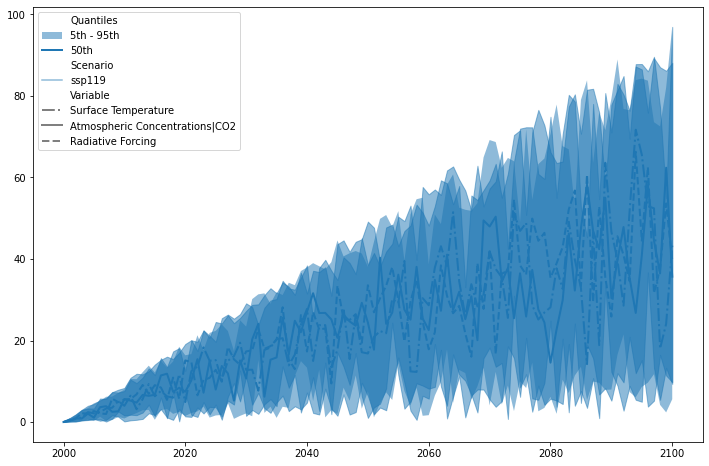

In [13]:
# NBVAL_IGNORE_OUTPUT
runs.plumeplot(quantile_over="run_id")

(<AxesSubplot:>,
  <matplotlib.lines.Line2D at 0x7f9993c98970>])

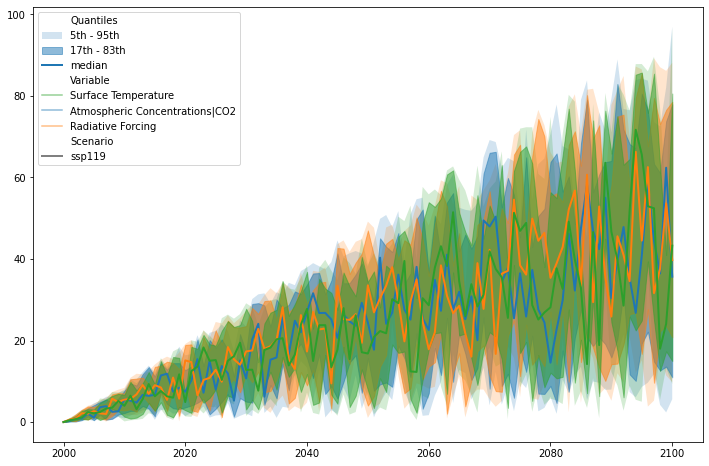

In [14]:
# NBVAL_IGNORE_OUTPUT
runs.plumeplot(
    quantile_over="run_id",
    quantiles_plumes=[
        ((0.05, 0.95), 0.2),
        ((0.17, 0.83), 0.5),
        (("median",), 1.0),
    ],
    hue_var="variable",
    hue_label="Variable",
    style_var="scenario",
    style_label="Scenario",
)

#### Pre-calculated quantiles

Alternately, we can cast the output of `quantiles_over` to an `ScmRun` object for ease of filtering and plotting.

In [15]:
# NBVAL_IGNORE_OUTPUT
summary_stats_scmrun = ScmRun(summary_stats)
summary_stats_scmrun

<scmdata.ScmRun (timeseries: 21, timepoints: 101)>
Time:
	Start: 2000-01-01T00:00:00
	End: 2100-01-01T00:00:00
Meta:
	      model quantile region scenario   unit                        variable
	0   example     0.05  World   ssp119    ppm  Atmospheric Concentrations|CO2
	1   example     0.05  World   ssp119  W/m^2               Radiative Forcing
	2   example     0.05  World   ssp119      K             Surface Temperature
	3   example     0.17  World   ssp119    ppm  Atmospheric Concentrations|CO2
	4   example     0.17  World   ssp119  W/m^2               Radiative Forcing
	5   example     0.17  World   ssp119      K             Surface Temperature
	6   example      0.5  World   ssp119    ppm  Atmospheric Concentrations|CO2
	7   example      0.5  World   ssp119  W/m^2               Radiative Forcing
	8   example      0.5  World   ssp119      K             Surface Temperature
	9   example     0.83  World   ssp119    ppm  Atmospheric Concentrations|CO2
	10  example     0.83  World   ssp11

As discussed above, casting the output of `quantiles_over` to an `ScmRun` object helps avoid repeatedly calculating the quantiles.

(<AxesSubplot:>,
  <matplotlib.lines.Line2D at 0x7f9993c2a970>])

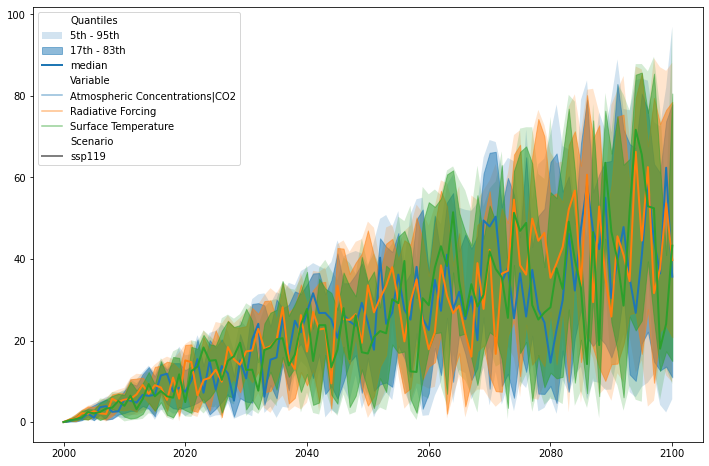

In [16]:
# NBVAL_IGNORE_OUTPUT
summary_stats_scmrun.plumeplot(
    quantiles_plumes=[
        ((0.05, 0.95), 0.2),
        ((0.17, 0.83), 0.5),
        (("median",), 1.0),
    ],
    hue_var="variable",
    hue_label="Variable",
    style_var="scenario",
    style_label="Scenario",
    pre_calculated=True,
)

If we don't want a plume plot, we can always our standard lineplot method.

<AxesSubplot:xlabel='time', ylabel='W/m^2'>

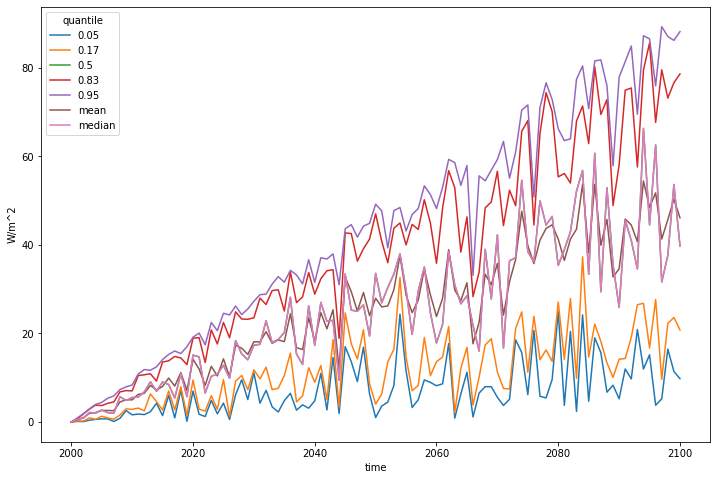

In [17]:
# NBVAL_IGNORE_OUTPUT
summary_stats_scmrun.filter(variable="Radiative Forcing").lineplot(
    hue="quantile"
)